In [183]:
"""
``autoreload`` is an IPython extension that reloads modules
automatically before executing the line of code typed.
"""

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Timeseries forecasting with LSTM model

---

## Loading modules and reading the data

In [184]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [185]:
print(f"Pandas version: {pd.__version__}")
print(f"TensorFlow version: {tf.__version__}")

Pandas version: 2.2.3
TensorFlow version: 2.10.0


In [186]:
RAW_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '01_raw'
PROCESSED_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '02_processed'
RAW_DATA_PATH

WindowsPath('c:/Users/Lyndon/Documents/University/CS3AM/coursework/CS3AM-COURSEWORK/data/01_raw')

In [187]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = [15, 8]

In [188]:
sns.set_style('whitegrid')

In [ ]:
def read_and_format_csv(subfolder_path: Path, raw_path: bool = True) -> pd.DataFrame:
    """
    Reads and formats a DataFrame correcting filetypes and date time values

    Args:
        subfolder_path (Path): Path to a csv file to read

    Returns:
        pd.DataFrame: formatted dataframe
    """
    if raw_path:
        path = str(RAW_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
    else:
        path = str(PROCESSED_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
        
    
    df = df.astype({col: 'float32' for col in ['Open', 'High', 'Low', 'Close', 'Adj Close',]})
    df['stock_name'] = df['stock_name'].astype('str')
    df['Volume'] = df['Volume'].astype('int32')

    df['Date'] = pd.to_datetime(df['Date'], format='ISO8601', utc='True')
    df['Date'] = pd.to_datetime(df['Date'].dt.date)
    return df

In [190]:
df = read_and_format_csv(subfolder_path='Information_Technology/AAPL.csv', raw_path=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


Make sure Dates are sorted

In [191]:
df.sort_values(by='Date', inplace=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


In [192]:
df.dtypes

Date          datetime64[ns]
Adj Close            float32
Close                float32
High                 float32
Low                  float32
Open                 float32
Volume                 int32
stock_name            object
dtype: object

## Focusing on Daily resolution and returns

<Axes: xlabel='Date', ylabel='Adj Close'>

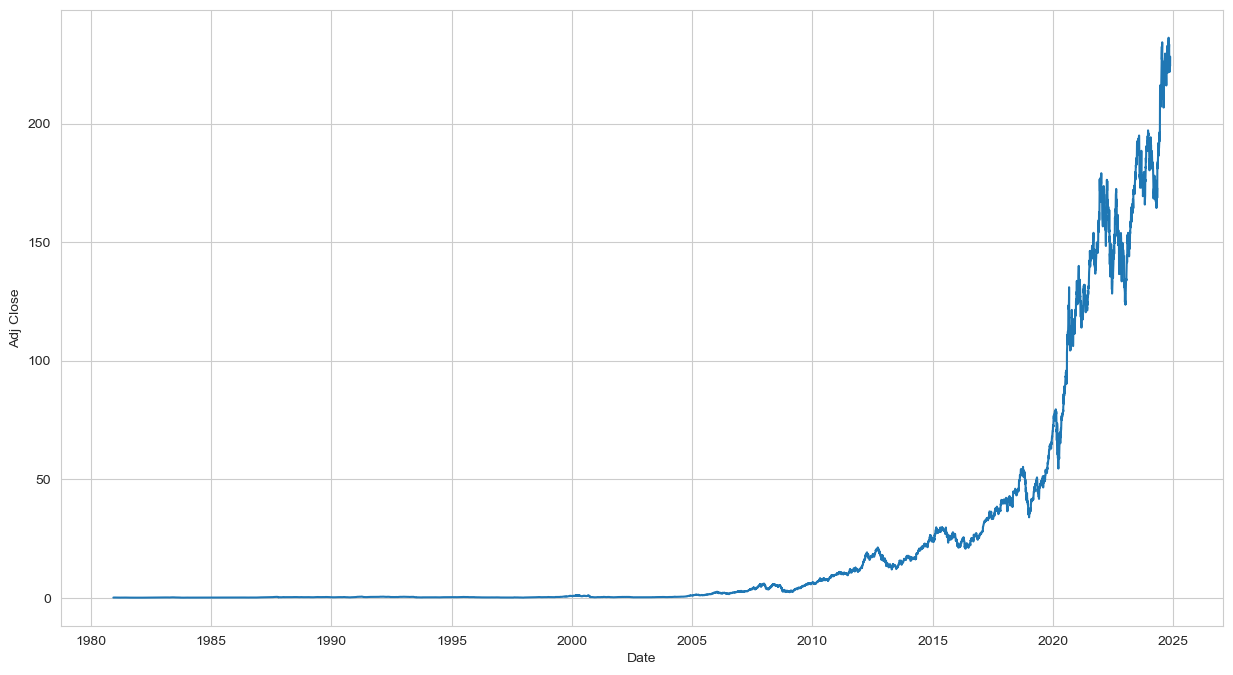

In [193]:
f, ax = plt.subplots(nrows=1, ncols=1,)

sns.lineplot(data=df, x='Date', y='Adj Close', markers='o')

In [194]:
df['Returns'] = df['Adj Close'].pct_change()
df['first_diff'] = df['Adj Close'].diff()
df

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL,NaN,NaN
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL,-0.052171,-0.005156
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL,-0.073397,-0.006876
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL,0.024751,0.002148
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL,0.028993,0.002579
...,...,...,...,...,...,...,...,...,...,...
11069,2024-11-08,226.960007,226.960007,228.660004,226.410004,227.169998,38328800,AAPL,-0.001188,-0.269989
11070,2024-11-11,224.229996,224.229996,225.699997,221.500000,225.000000,42005600,AAPL,-0.012029,-2.730011
11071,2024-11-12,224.229996,224.229996,225.589996,223.360001,224.550003,40398300,AAPL,0.000000,0.000000
11072,2024-11-13,225.119995,225.119995,226.649994,222.759995,224.009995,48566200,AAPL,0.003969,0.889999


In [195]:
df = df.loc[df['Date'].dt.year > pd.Timestamp('1980').year].reset_index(drop=True)
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1981-01-02,0.118602,0.154018,0.155134,0.154018,0.154018,21660800,AAPL,0.010989,0.001289
1,1981-01-05,0.116024,0.150670,0.151228,0.150670,0.151228,35728000,AAPL,-0.021738,-0.002578


In [196]:
df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Date,Adj Close,Close,High,Low,Open,Volume,Returns,first_diff
count,11061,11061.000000,11061.000000,11061.000000,11061.000000,11061.000000,1.106100e+04,11061.000000,11061.000000
mean,2002-11-30 02:56:32.026037376,22.893742,23.732557,23.969788,23.473480,23.716425,3.025108e+08,0.001077,0.020622
min,1981-01-02 00:00:00,0.037815,0.049107,0.049665,0.049107,0.049665,-2.108338e+09,-0.518692,-10.566132
10%,1985-05-16 00:00:00,0.103992,0.134487,0.137277,0.132813,0.135045,6.835660e+07,-0.028096,-0.176617
25%,1991-12-09 00:00:00,0.243658,0.300781,0.306429,0.292411,0.300223,1.110652e+08,-0.012620,-0.008989
50%,2002-11-25 00:00:00,0.442485,0.540179,0.549107,0.531250,0.540179,2.030448e+08,0.000000,0.000000
75%,2013-11-19 00:00:00,17.913139,20.999643,21.236429,20.821428,21.079287,3.933552e+08,0.014385,0.014069
90%,2020-06-24 00:00:00,87.711876,90.014999,91.250000,88.254997,90.019997,7.011536e+08,0.030815,0.261644
99%,2024-06-08 04:48:00,197.054633,198.020004,198.887994,195.934000,197.151996,1.504470e+09,0.077555,3.431161
max,2024-11-14 00:00:00,236.220108,236.479996,237.490005,234.449997,236.479996,2.127171e+09,0.332281,13.998383


In [197]:
df.dropna(inplace=True)

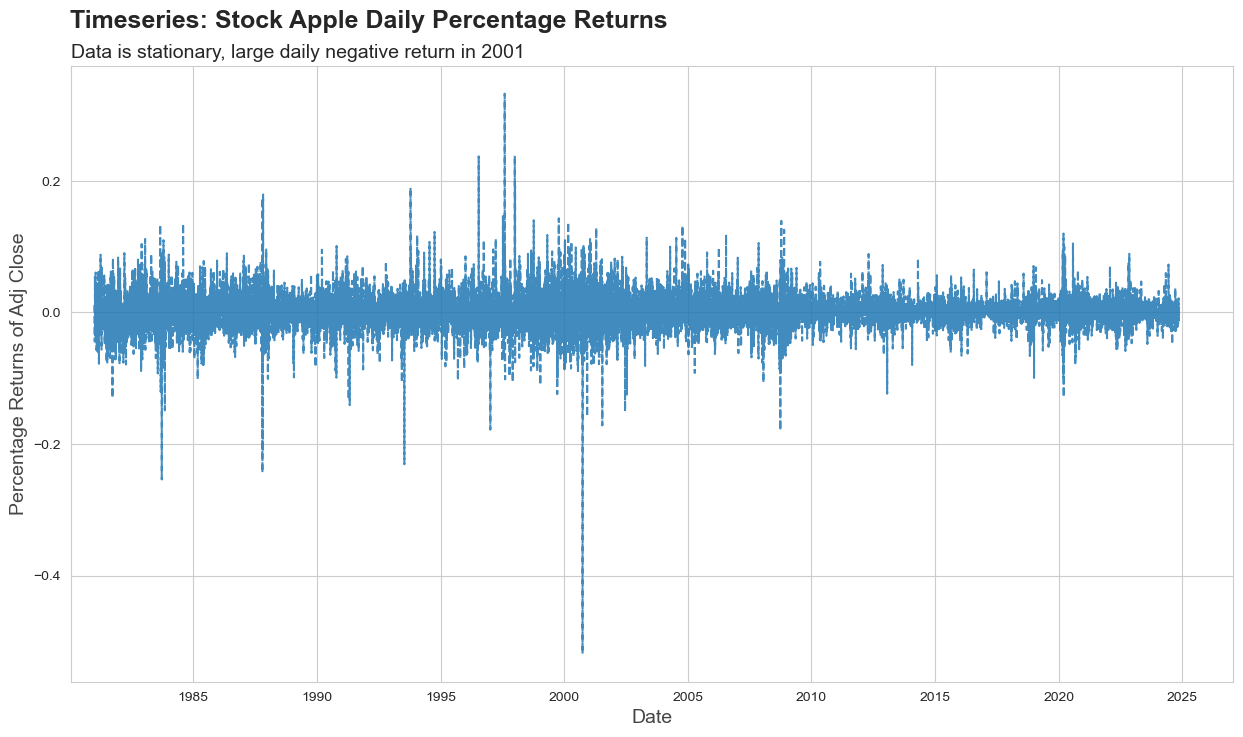

In [198]:
f, ax = plt.subplots()
sns.lineplot(data=df, x='Date', y='Returns', linestyle='--', markers='o', ax=ax, alpha=0.85)


ax.set_xlabel('Date', fontsize=14, alpha=0.85)
ax.set_ylabel('Percentage Returns of Adj Close', fontsize=14, alpha=0.85)

dx, dy = 0.3235, 0.95
f.suptitle(t='Timeseries: Stock Apple Daily Percentage Returns', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Data is stationary, large daily negative return in 2001', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))

plt.show()


---

## Deep Modelling

---

In [ ]:
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.metrics as metrics

tf.random.set_seed(42)


In [200]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Prepare Inputs Values for model 

In [201]:
df_deep = df[['Date', 'Adj Close']].set_index('Date')
df_deep.head()

,Adj Close
Date,
1981-01-02,0.118602
1981-01-05,0.116024
1981-01-06,0.110867
1981-01-07,0.106140
1981-01-08,0.103992


In [202]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_deep['Adj Close'] = scaler.fit_transform(df_deep[['Adj Close']])
df_deep.head()

,Adj Close
Date,
1981-01-02,0.000342
1981-01-05,0.000331
1981-01-06,0.000309
1981-01-07,0.000289
1981-01-08,0.000280


In [203]:
# df_deep = df_deep.iloc[1000:10_000, :]

create a sequence of 10 daily trading lags which will be used to forecast values 

In [ ]:
# Create sequences for LSTM
sequence_length = 10 # lenght 10 for 10 trading days
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length)]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


X, y = create_sequences(df_deep['Adj Close'].values, sequence_length)


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [205]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, 
         input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


model.compile(optimizer='adam', loss='mse', metrics=[metrics.RootMeanSquaredError(), metrics.MeanAbsolutePercentageError(), metrics.MeanAbsoluteError()])

do i need to pass in returns or can i just pass in adj close

In [206]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/200
221/221 [==============================] - 7s 26ms/step - loss: 6.6739e-06 - root_mean_squared_error: 0.0026 - mean_absolute_percentage_error: 284.8199 - mean_absolute_error: 0.0015 - val_loss: 6.3803e-04 - val_root_mean_squared_error: 0.0253 - val_mean_absolute_percentage_error: 26.9326 - val_mean_absolute_error: 0.0202
Epoch 2/200
221/221 [==============================] - 5s 24ms/step - loss: 1.9068e-06 - root_mean_squared_error: 0.0014 - mean_absolute_percentage_error: 367.6333 - mean_absolute_error: 8.4959e-04 - val_loss: 5.3046e-04 - val_root_mean_squared_error: 0.0230 - val_mean_absolute_percentage_error: 26.1150 - val_mean_absolute_error: 0.0190
Epoch 3/200
221/221 [==============================] - 5s 25ms/step - loss: 1.6048e-06 - root_mean_squared_error: 0.0013 - mean_absolute_percentage_error: 232.8437 - mean_absolute_error: 7.5134e-04 - val_loss: 3.3588e-04 - val_root_mean_squared_error: 0.0183 - val_mean_absolute_percentage_error: 20.7115 - val_mean_absolute_e

In [207]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_rmse = np.sqrt(np.mean((y_train - train_pred) ** 2))
test_rmse = np.sqrt(np.mean((y_test - test_pred) ** 2))

print(train_rmse, test_rmse)

70/70 [==============================] - 0s 5ms/step
0.036494654 0.3463337


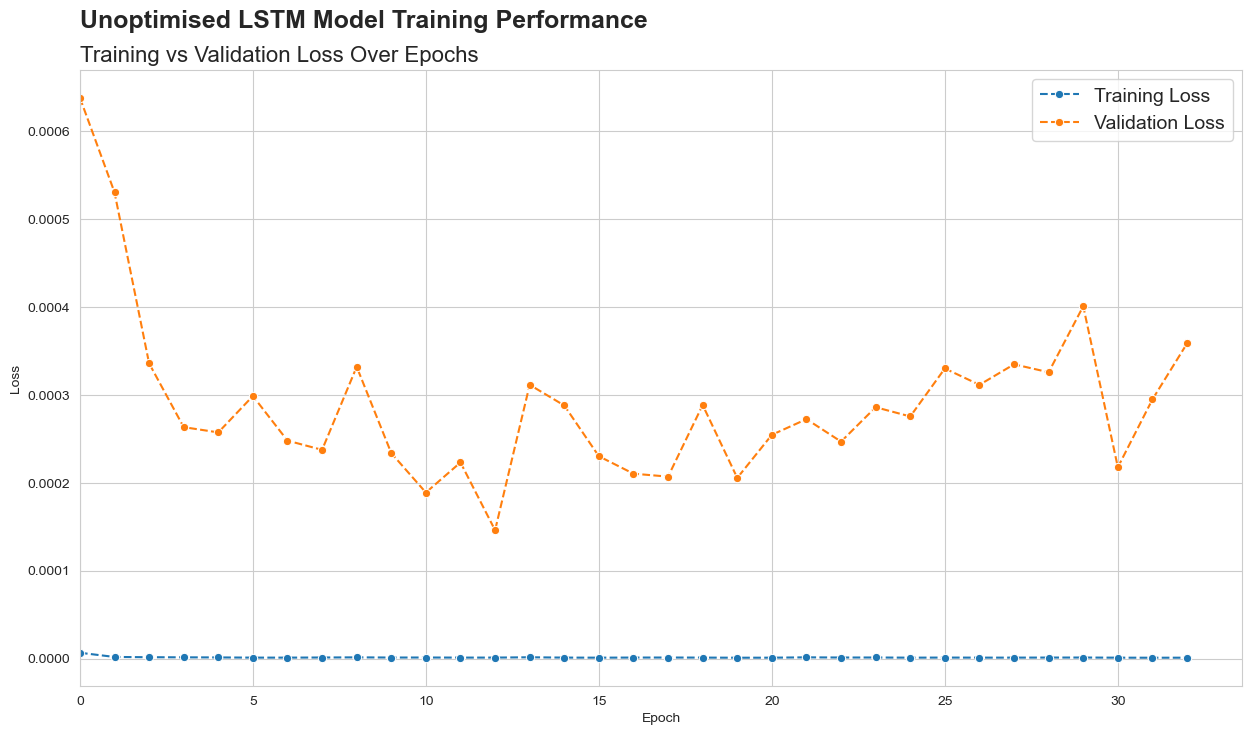

In [208]:
f, ax = plt.subplots()


sns.lineplot(history.history['loss'], label='Training Loss', marker='o', linestyle='--')
sns.lineplot(history.history['val_loss'], label='Validation Loss', marker='o', linestyle='--')

ax.set_title('Training vs Validation Loss Over Epochs', fontsize=16, fontweight='light', loc='left')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

dx, dy = 0.314, 0.955
f.suptitle(t='Unoptimised LSTM Model Training Performance', fontsize=18, x=dx, y=dy, fontweight='bold')

ax.legend(fontsize=14)


ax.set_xlim(0)
plt.show()

f.savefig('../outputs/figures/unoptimsed_lstm_loss.png', dpi=300)

70/70 [==============================] - 0s 6ms/step


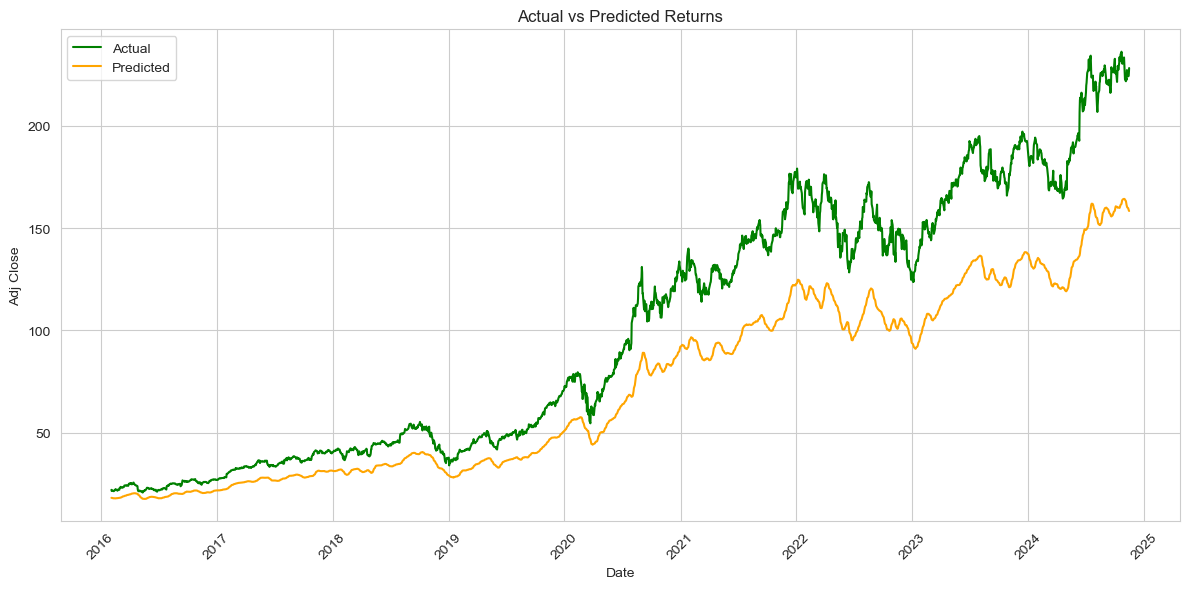

In [209]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

forecast_dates = df_deep.index[train_size + sequence_length:]
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten()
})


plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Actual'], label='Actual', color='green')
plt.plot(forecast_df['Date'], forecast_df['Predicted'], label='Predicted', color='orange')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


look at how it is testing our of sample training phase

70/70 [==============================] - 0s 5ms/step


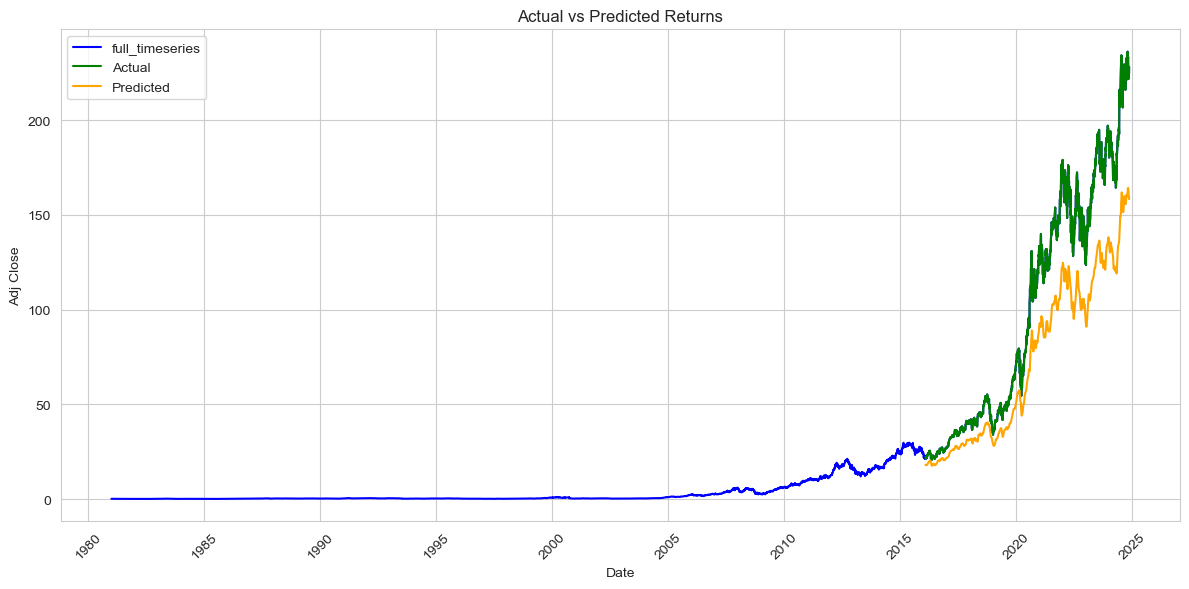

In [210]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# DataFrame with the original dates, actual values, and predicted values
forecast_dates = df_deep.index[train_size + sequence_length:]
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten()
})

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Adj Close'], label='full_timeseries', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Actual'], label='Actual', color='green')
plt.plot(forecast_df['Date'], forecast_df['Predicted'], label='Predicted', color='orange')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [211]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_percentage_error', 'mean_absolute_error', 'val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error'])

In [229]:
metrics = model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {metrics[0]:.4f}, RMSE: {metrics[1]:.4f}, MAPE: {metrics[2]:.4f}%, MAE: {metrics[3]:.4f}")

70/70 - 1s - loss: 0.0213 - root_mean_squared_error: 0.1459 - mean_absolute_percentage_error: 26.0313 - mean_absolute_error: 0.1193 - 636ms/epoch - 9ms/step
Loss: 0.0213, RMSE: 0.1459, MAPE: 26.0313%, MAE: 0.1193


In [213]:
forecast_df.head()

,Date,Actual,Predicted
0,2016-02-04,21.997526,18.078480
1,2016-02-05,21.410013,18.068556
2,2016-02-08,21.635454,17.976973
3,2016-02-09,21.630905,17.916870
4,2016-02-10,21.466942,17.850698


In [214]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [215]:
mean_squared_error(forecast_df['Actual'], forecast_df['Predicted'], squared=False)
mean_absolute_percentage_error(forecast_df['Actual'], forecast_df['Predicted'])

0.2601665

In [ ]:
# model.save('../models/model_outputs/pre_hyperparam_tuning/unoptimised_forecasting_deep_model.h5')

In [217]:
from keras.models import load_model

In [218]:
optimised_models = load_model("../models/model_outputs/post_hyperparam_tuning/keras_tuning_best_LSTM.h5")

In [219]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    # patience=5,
    restore_best_weights=True
)

history = optimised_models.fit(
    X_train, y_train,
    epochs=200,
    # epochs=50,
    batch_size=32,
    # batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/200
221/221 [==============================] - 7s 26ms/step - loss: 5.3825e-06 - root_mean_squared_error: 0.0023 - mean_absolute_percentage_error: 328.4299 - mean_absolute_error: 0.0012 - val_loss: 3.0171e-04 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_percentage_error: 18.0313 - val_mean_absolute_error: 0.0137
Epoch 2/200
221/221 [==============================] - 6s 25ms/step - loss: 2.2743e-07 - root_mean_squared_error: 4.7690e-04 - mean_absolute_percentage_error: 124.3701 - mean_absolute_error: 3.3411e-04 - val_loss: 3.1322e-04 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_percentage_error: 18.8250 - val_mean_absolute_error: 0.0141
Epoch 3/200
221/221 [==============================] - 6s 26ms/step - loss: 3.0298e-07 - root_mean_squared_error: 5.5044e-04 - mean_absolute_percentage_error: 106.1208 - mean_absolute_error: 4.0917e-04 - val_loss: 2.4447e-04 - val_root_mean_squared_error: 0.0156 - val_mean_absolute_percentage_error: 15.9566 - val_mean_ab

In [220]:
train_pred = optimised_models.predict(X_train)
test_pred = optimised_models.predict(X_test)

train_rmse = np.sqrt(np.mean((y_train - train_pred) ** 2))
test_rmse = np.sqrt(np.mean((y_test - test_pred) ** 2))
print(train_rmse, test_rmse)

70/70 [==============================] - 0s 6ms/step
0.03979814 0.36869234


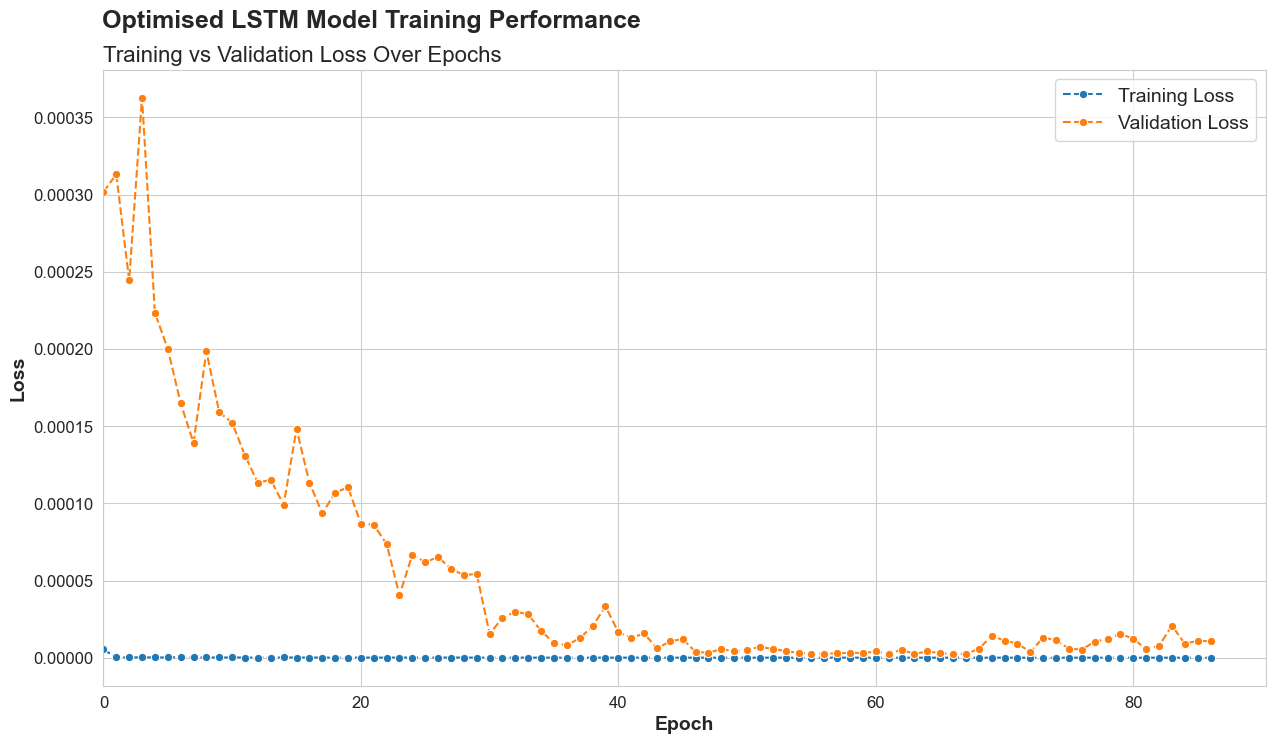

In [221]:
f, ax = plt.subplots()


sns.lineplot(history.history['loss'], label='Training Loss', marker='o', linestyle='--')
sns.lineplot(history.history['val_loss'], label='Validation Loss', marker='o', linestyle='--')

ax.set_title('Training vs Validation Loss Over Epochs', fontsize=16, fontweight='light', loc='left')
ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax.set_ylabel('Loss', fontsize=14, fontweight='bold')

dx, dy = 0.304, 0.955
f.suptitle(t='Optimised LSTM Model Training Performance', fontsize=18, x=dx, y=dy, fontweight='bold')

ax.legend(fontsize=14)


ax.set_xlim(0)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

f.savefig('../outputs/figures/optimsed_lstm_loss.png', dpi=300)

In [222]:
y_pred = optimised_models.predict(X_test)
y_pred_unptimised = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_unoptimised_inv = scaler.inverse_transform(y_pred_unptimised)
y_pred_inv = scaler.inverse_transform(y_pred)

forecast_dates = df_deep.index[train_size + sequence_length:]
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten(),
    'Unoptimised_predicted': y_pred_unoptimised_inv.flatten()
})


70/70 [==============================] - 0s 6ms/step


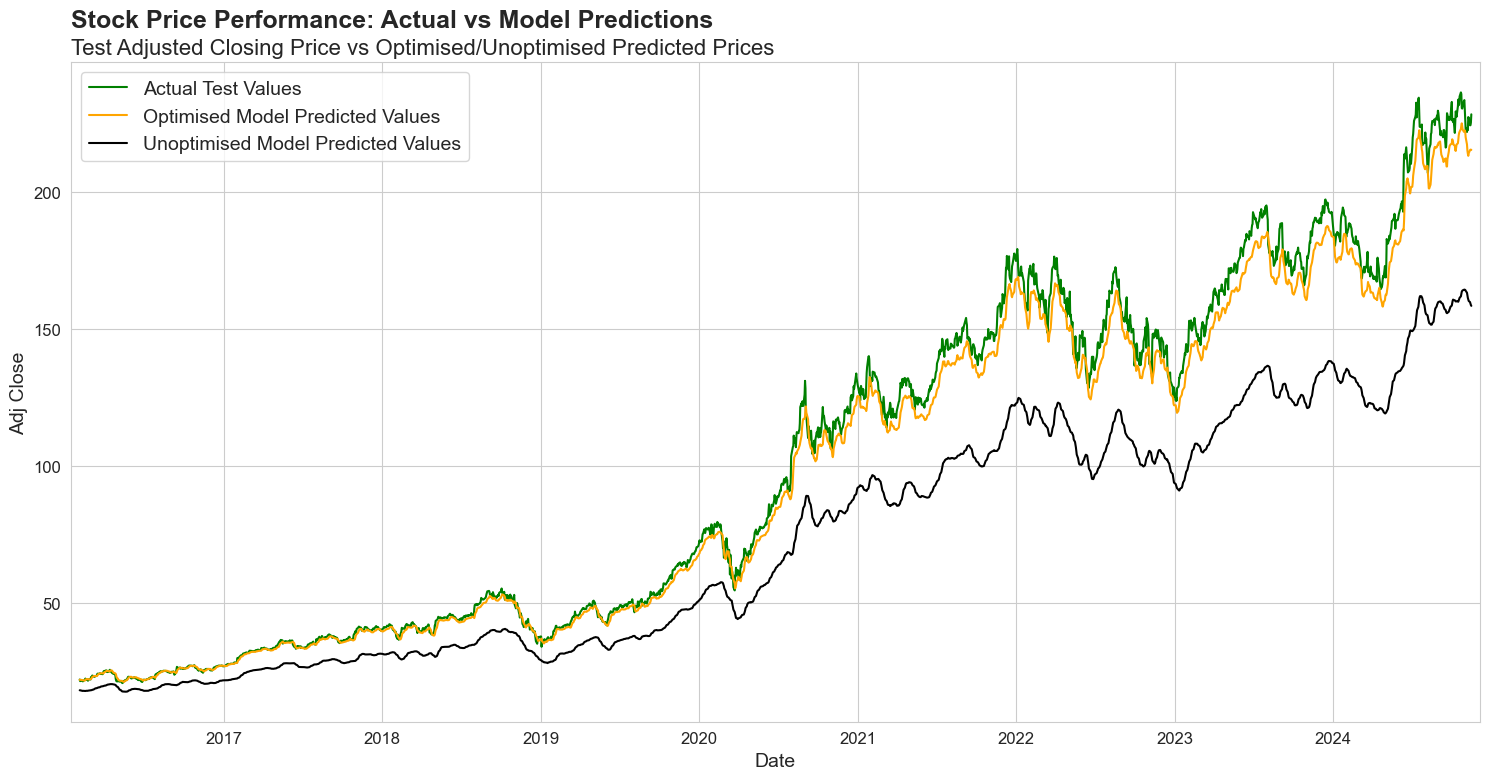

In [223]:
f, ax = plt.subplots()

sns.lineplot(x=forecast_df['Date'], y=forecast_df['Actual'], label='Actual Test Values', color='green')
sns.lineplot(x=forecast_df['Date'], y=forecast_df['Predicted'], label='Optimised Model Predicted Values', color='orange')
sns.lineplot(x=forecast_df['Date'], y=forecast_df['Unoptimised_predicted'], label='Unoptimised Model Predicted Values', color='black')

ax.set_title('Test Adjusted Closing Price vs Optimised/Unoptimised Predicted Prices', loc='left', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Adj Close', fontsize=14)

ax.legend(fontsize=14)
ax.set_xlim(forecast_df['Date'].min() -  timedelta(days=20), forecast_df['Date'].max() + timedelta(days=20))
ax.tick_params(axis='both', which='major', labelsize=12)

dx, dy = 0.265, 0.97
f.suptitle(t="Stock Price Performance: Actual vs Model Predictions", fontsize=18, fontweight='bold', x=dx, y=dy)

plt.tight_layout()
plt.show()

f.savefig("../outputs/figures/deep_stock_price_forecast.png", dpi=300)

In [224]:
forecast_df['Date'].max() - forecast_df['Date'].min()

Timedelta('3206 days 00:00:00')

In [225]:
metrics = model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {metrics[0]:.4f}, RMSE: {metrics[1]:.4f}, MAPE: {metrics[2]:.4f}%, MAE: {metrics[3]:.4f}")

70/70 - 1s - loss: 0.0213 - root_mean_squared_error: 0.1459 - mean_absolute_percentage_error: 26.0313 - mean_absolute_error: 0.1193 - 542ms/epoch - 8ms/step
Loss: 0.0213, RMSE: 0.1459, MAPE: 26.0313%, MAE: 0.1193


In [226]:
optimised_metrics = optimised_models.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {optimised_metrics[0]:.4f}, RMSE: {optimised_metrics[1]:.4f}, MAPE: {optimised_metrics[2]:.4f}%, MAE: {optimised_metrics[3]:.4f}")

70/70 - 1s - loss: 6.4582e-04 - root_mean_squared_error: 0.0254 - mean_absolute_percentage_error: 3.6049 - mean_absolute_error: 0.0185 - 549ms/epoch - 8ms/step
Loss: 0.0006, RMSE: 0.0254, MAPE: 3.6049%, MAE: 0.0185


Optimised model performed really well

In [227]:
type(model)

keras.engine.sequential.Sequential